# Data Science Project Part 1 &ndash; Assessing the System Load
_CAS ADS 2019_<br/>
_Author: Marco Bassi_, September 8, 2019

## Introduction

### Situation
The SBB project KiHub operates the CUS platform, a datahub for the real-time data of the Swiss public transport. One of the core components it the CUS DB, an Oracle RDBMS. There is the **CUS DB Prod** for the productive environment, and the **CUS DB Inte** for the release test environment. Each database runs on its own, dedicated Oracle Data Appliance (ODA). Each database consists two database instances, running in cluster mode (Oracle Real Application Cluster).

Upon an upgrade of its grid infrastructure, the performance of the CUS DB Inte deteriorated to a degree, where it wouldn't meet anymore its purpose for the release test. The performance issues manifested themselves mainly in a massive degradation of the cluster-related wait times. 

In the beginning of August, a number of patches was applied to improve the performance. The goal of this analysis is to evaluate the performance of the CUS DB Inte, by compairing it with the CUS DB Prod. For this purpose, some selected system statistics are gathered from the _Oracle dynamic performance view_ DBA_HIST_SYSSTAT. This view contains hourly snapshots of historicised system statistics.
The statistics are running sums, with their values beeing reset upon system restart.

### Data Analysis
The analysis is made of two parts:
1. Part 1 analyses the system load of the two databases. Similar system load is a major precondition for drawing conclusions of the performance of the CUS DB Inte, when compaired to CUS DB Prod.
2. Part 2 specifically analyses statistics related to the Global Cache (GC). GC is involved when one cluster database instance requires data currently held in the Local Cache (LC) of the other cluster database instance. The handling of this situation is ruled by a sophisticated protocol, which however is out of scope of this analysis.

### Read the data

In [3]:
setwd('/data/CAS-ADS/Git.repos/CAS-Applied-Data-Science/Data-Science-Project/project.1/statistiken.2019-08-22T0000-bis-2019-08-28T1000/data')
daten.inte <- read.csv2(file="dba_hist_sysstat.inte.dsv", sep=";", dec=".", stringsAsFactors=F)
str(daten.inte)

'data.frame':	232897 obs. of  6 variables:
 $ BEGIN_INTERVAL_TIME: chr  "2019-08-22 00:00:05" "2019-08-22 00:00:05" "2019-08-22 00:00:05" "2019-08-22 00:00:05" ...
 $ END_INTERVAL_TIME  : chr  "2019-08-22 01:00:22" "2019-08-22 01:00:22" "2019-08-22 01:00:22" "2019-08-22 01:00:22" ...
 $ SNAP_ID            : int  20070 20070 20070 20070 20070 20070 20070 20070 20070 20070 ...
 $ INSTANCE_NUMBER    : int  2 2 2 2 2 2 2 2 2 2 ...
 $ STAT_NAME          : chr  "active txn count during cleanout" "ADG parselock X get attempts" "ADG parselock X get successes" "application wait time" ...
 $ VALUE              : num  94067174 0 0 24287453 0 ...


In [4]:
daten.prod <- read.csv2(file="dba_hist_sysstat.prod.dsv", sep=";", dec=".", stringsAsFactors=F)
str(daten.prod)

'data.frame':	239008 obs. of  6 variables:
 $ BEGIN_INTERVAL_TIME: chr  "2019-08-22 00:00:14" "2019-08-22 00:00:14" "2019-08-22 00:00:14" "2019-08-22 00:00:14" ...
 $ END_INTERVAL_TIME  : chr  "2019-08-22 01:00:16" "2019-08-22 01:00:16" "2019-08-22 01:00:16" "2019-08-22 01:00:16" ...
 $ SNAP_ID            : int  35567 35567 35567 35567 35567 35567 35567 35567 35567 35567 ...
 $ INSTANCE_NUMBER    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ STAT_NAME          : chr  "active txn count during cleanout" "ADG parselock X get attempts" "ADG parselock X get successes" "application wait time" ...
 $ VALUE              : num  5.11e+08 0.00 0.00 8.39e+07 1.19e+02 ...


In [5]:
## Use data.table library
library(data.table)
dt.inte <- data.table(daten.inte)
dt.prod <- data.table(daten.prod)
head(dt.prod, 10)

BEGIN_INTERVAL_TIME,END_INTERVAL_TIME,SNAP_ID,INSTANCE_NUMBER,STAT_NAME,VALUE
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,active txn count during cleanout,511403667
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,ADG parselock X get attempts,0
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,ADG parselock X get successes,0
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,application wait time,83919815
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,auto extends on undo tablespace,119
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,background checkpoints completed,6195
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,background checkpoints started,6195
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,background timeouts,156219454
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,Batched IO block miss count,8136763326
2019-08-22 00:00:14,2019-08-22 01:00:16,35567,1,Batched IO (bound) vector count,67038018


### As the statistics are running sums, they have to be "nulled" with respect to the oldest snapshot common to the two instances of a cluster.

In [6]:
# find the minimum snaphost ID for the CUS DB Inte data
minsnap.inte <- dt.inte[, min(SNAP_ID), by=INSTANCE_NUMBER]

# select the minimum snapshot data
mindt.inte <- merge(dt.inte, minsnap.inte, by.x=c("INSTANCE_NUMBER", "SNAP_ID"), by.y=c("INSTANCE_NUMBER", "V1"), all=F)
dtNulled.inte <- merge(dt.inte, mindt.inte[, list(INSTANCE_NUMBER, STAT_NAME, VALUE)] , by=c("INSTANCE_NUMBER", "STAT_NAME"), suffixes=c("", 0),all.x = T)

# Check if there are NA statistic values
sum(is.na(dtNulled.inte[, c('VALUE', 'VALUE0')]))  # must be 0

# Compute the nulled value, i.e. the statics value of all snapshots and statistics wrt. the minimum snapshot data
dtNulled.inte[, offsetValue := VALUE - VALUE0]
str(dtNulled.inte)

[1] 0

Classes 'data.table' and 'data.frame':	232897 obs. of  8 variables:
 $ INSTANCE_NUMBER    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ STAT_NAME          : chr  "ADG parselock X get attempts" "ADG parselock X get attempts" "ADG parselock X get attempts" "ADG parselock X get attempts" ...
 $ BEGIN_INTERVAL_TIME: chr  "2019-08-22 00:00:05" "2019-08-22 01:00:22" "2019-08-22 02:00:46" "2019-08-22 03:00:40" ...
 $ END_INTERVAL_TIME  : chr  "2019-08-22 01:00:22" "2019-08-22 02:00:46" "2019-08-22 03:00:40" "2019-08-22 04:00:21" ...
 $ SNAP_ID            : int  20070 20071 20072 20073 20074 20075 20076 20077 20078 20079 ...
 $ VALUE              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ VALUE0             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ offsetValue        : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "INSTANCE_NUMBER" "STAT_NAME"


In [7]:
# same procedure for CUS DB Prod data
minsnap.prod <- dt.prod[, min(SNAP_ID), by=INSTANCE_NUMBER]
mindt.prod <- merge(dt.prod, minsnap.prod, by.x=c("INSTANCE_NUMBER", "SNAP_ID"), by.y=c("INSTANCE_NUMBER", "V1"), all=F)
dtNulled.prod <- merge(dt.prod, mindt.prod[, list(INSTANCE_NUMBER, STAT_NAME, VALUE)] , by=c("INSTANCE_NUMBER", "STAT_NAME"), suffixes=c("", 0),all.x = T)
sum(is.na(dtNulled.prod[, c('VALUE', 'VALUE0')]))  # must be 0
dtNulled.prod[, offsetValue := VALUE - VALUE0]
str(dtNulled.prod)

[1] 0

Classes 'data.table' and 'data.frame':	239008 obs. of  8 variables:
 $ INSTANCE_NUMBER    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ STAT_NAME          : chr  "ADG parselock X get attempts" "ADG parselock X get attempts" "ADG parselock X get attempts" "ADG parselock X get attempts" ...
 $ BEGIN_INTERVAL_TIME: chr  "2019-08-22 00:00:14" "2019-08-22 01:00:16" "2019-08-22 02:00:01" "2019-08-22 03:00:07" ...
 $ END_INTERVAL_TIME  : chr  "2019-08-22 01:00:16" "2019-08-22 02:00:01" "2019-08-22 03:00:07" "2019-08-22 04:00:20" ...
 $ SNAP_ID            : int  35567 35568 35569 35570 35571 35572 35573 35574 35575 35576 ...
 $ VALUE              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ VALUE0             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ offsetValue        : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "INSTANCE_NUMBER" "STAT_NAME"


In [8]:
# Compute datetime values from character strings
dtNulled.inte[, beginInterval := as.POSIXct(BEGIN_INTERVAL_TIME, format="%Y-%m-%d %H:%M:%S")]
dtNulled.inte[, endInterval := as.POSIXct(END_INTERVAL_TIME, format="%Y-%m-%d %H:%M:%S")]
dtNulled.inte[, snapHour := as.POSIXct(round(beginInterval, units="hours"))]
str(dtNulled.inte)

dtNulled.prod[, beginInterval := as.POSIXct(BEGIN_INTERVAL_TIME, format="%Y-%m-%d %H:%M:%S")]
dtNulled.prod[, endInterval := as.POSIXct(END_INTERVAL_TIME, format="%Y-%m-%d %H:%M:%S")]
dtNulled.prod[, snapHour := as.POSIXct(round(beginInterval, units="hours"))]
str(dtNulled.prod)

Classes 'data.table' and 'data.frame':	232897 obs. of  11 variables:
 $ INSTANCE_NUMBER    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ STAT_NAME          : chr  "ADG parselock X get attempts" "ADG parselock X get attempts" "ADG parselock X get attempts" "ADG parselock X get attempts" ...
 $ BEGIN_INTERVAL_TIME: chr  "2019-08-22 00:00:05" "2019-08-22 01:00:22" "2019-08-22 02:00:46" "2019-08-22 03:00:40" ...
 $ END_INTERVAL_TIME  : chr  "2019-08-22 01:00:22" "2019-08-22 02:00:46" "2019-08-22 03:00:40" "2019-08-22 04:00:21" ...
 $ SNAP_ID            : int  20070 20071 20072 20073 20074 20075 20076 20077 20078 20079 ...
 $ VALUE              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ VALUE0             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ offsetValue        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ beginInterval      : POSIXct, format: "2019-08-22 00:00:05" "2019-08-22 01:00:22" ...
 $ endInterval        : POSIXct, format: "2019-08-22 01:00:22" "2019-08-22 02:00:46" ...
 $ snapHour           : POSIXct, format: "2019-08

### There are some tests to show the snapshot intervals are identical. These tests are skipped here.

In [9]:
# Sum up the statistics values of the CUS DB Inte database instances
dtNulled.inte1 <- dtNulled.inte[, list("minInterval" = min(beginInterval), "maxInterval" = max(endInterval), "sumValue" = sum(offsetValue)),
   by = list(SNAP_ID, STAT_NAME, snapHour)]
   
# Same for the CUS DB Prod
dtNulled.prod1 <- dtNulled.prod[, list("minInterval" = min(beginInterval), "maxInterval" = max(endInterval), "sumValue" = sum(offsetValue)),
   by = list(SNAP_ID, STAT_NAME, snapHour)]

# Merge the data tables of CUS DB Prod and CUS DB Inte.The snapshots at August 29, 1:00 CEST and later are dropped because CUS DB Prod was restarted.
dtNulled <- merge(
   dtNulled.inte1[snapHour < as.POSIXct(strptime('2019-08-29 01:00:00', '%Y-%m-%d %H:%M:%S')), list(STAT_NAME, snapHour, sumValue)],
   dtNulled.prod1[snapHour < as.POSIXct(strptime('2019-08-29 01:00:00', '%Y-%m-%d %H:%M:%S')), list(STAT_NAME, snapHour, sumValue)],
   by=c("snapHour", "STAT_NAME"), all=T, suffixes=c("_I", "_P"), incomparables=NA)

setkeyv(dtNulled, c("snapHour", "STAT_NAME"))

# sumValue_I holds the statistics values of CUS DB Inte, and sumValue_P for CUS DB Prod respectively
str(dtNulled)

Classes 'data.table' and 'data.frame':	114751 obs. of  4 variables:
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ STAT_NAME : chr  "ADG parselock X get attempts" "ADG parselock X get successes" "Batched IO (bound) vector count" "Batched IO (full) vector count" ...
 $ sumValue_I: num  0 0 0 0 0 0 0 0 0 0 ...
 $ sumValue_P: num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "snapHour" "STAT_NAME"


### Choose the statistics to compaire the two databases loads:
* application wait time (in centiseconds)
* cluster wait time (in centiseconds)
* concurrency wait time (in centiseconds)
* user I/O wait time (in centiseconds)
* db block changes (number)
* enqueue requests (number)
* execute count (number)
* global enqueue gets async (number)
* global enqueue gets sync (number)
* parse count (total, number)
* user calls (number)

In [10]:
dtNulled.selectForLoad <- dtNulled[ STAT_NAME %in% list(
'db block changes', 'enqueue requests', 'execute count', 'global enqueue gets async', 'global enqueue gets sync', 
'parse count (total)', 'user calls', 'application wait time', 'cluster wait time', 'user I/O wait time', 'concurrency wait time'), ]
str(dtNulled.selectForLoad)

Classes 'data.table' and 'data.frame':	1859 obs. of  4 variables:
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ STAT_NAME : chr  "application wait time" "cluster wait time" "concurrency wait time" "db block changes" ...
 $ sumValue_I: num  0 0 0 0 0 0 0 0 0 0 ...
 $ sumValue_P: num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "snapHour" "STAT_NAME"


In [11]:
# Transform the data.table into long format for furhter analysis
library(reshape2)
dtNulled.selectForLoad.melt <- melt(dtNulled.selectForLoad, id=c("snapHour", "STAT_NAME"), measured=c("sumValue_I","sumValue_P"))
str(dtNulled.selectForLoad.melt)


Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt



Classes 'data.table' and 'data.frame':	3718 obs. of  4 variables:
 $ snapHour : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ STAT_NAME: chr  "application wait time" "cluster wait time" "concurrency wait time" "db block changes" ...
 $ variable : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 1 1 1 1 1 1 1 1 1 ...
 $ value    : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [12]:
# get a summary
library(broom)
summarySystatByPlatform <- dtNulled.selectForLoad.melt[!is.na(value), glance(summary(value)), by=list(STAT_NAME, variable)]
setkeyv(summarySystatByPlatform, c("STAT_NAME", "variable"))
summarySystatByPlatform

STAT_NAME,variable,minimum,q1,median,mean,q3,maximum
application wait time,sumValue_I,0,6469607,13006096,11218856,15822376,24605502
application wait time,sumValue_P,0,1765437,3286549,3836112,5671957,11161610
cluster wait time,sumValue_I,0,39922870,70648925,73811537,106550893,156068270
cluster wait time,sumValue_P,0,13095362,23202828,22954916,32902095,45809061
concurrency wait time,sumValue_I,0,20483283,45683929,37344386,56770050,65431988
concurrency wait time,sumValue_P,0,8524217,13795452,13850108,19123212,27798021
db block changes,sumValue_I,0,2091862563,3998385106,4058133163,6014315921,8178806280
db block changes,sumValue_P,0,2231984641,3948820716,3960612971,5725933415,7850867824
enqueue requests,sumValue_I,0,168693903,315319718,324797038,480036301,667086207
enqueue requests,sumValue_P,0,361319940,642784679,651501529,947107722,1314715516


### Produce some diagrams

In [13]:
tstart <- dtNulled.selectForLoad.melt[, min(snapHour)]
tend <- dtNulled.selectForLoad.melt[, max(snapHour)]
tscale = seq(from=tstart, to=tend, by=24*3600)

lims <- c(tstart,tend)

library(ggplot2)

myTheme = theme(
  aspect.ratio = 0.8,
##  plot.margin = margin(c(0.5, 1, 0.5, 1), "cm"),
  plot.title=element_text(size = 10, face="bold"),
  title = element_text(size = 9),
  axis.title.x = element_text(size = 7),
  axis.text.x = element_text(size = 7),
  axis.title.y = element_text(size = 7),
  axis.text.y = element_text(size = 7),
  legend.title = element_text(size = 8, face="bold"),
  legend.text = element_text(size = 7)
)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


#### Application Waitclass

Warning message:
"Removed 6 rows containing missing values (geom_col)."

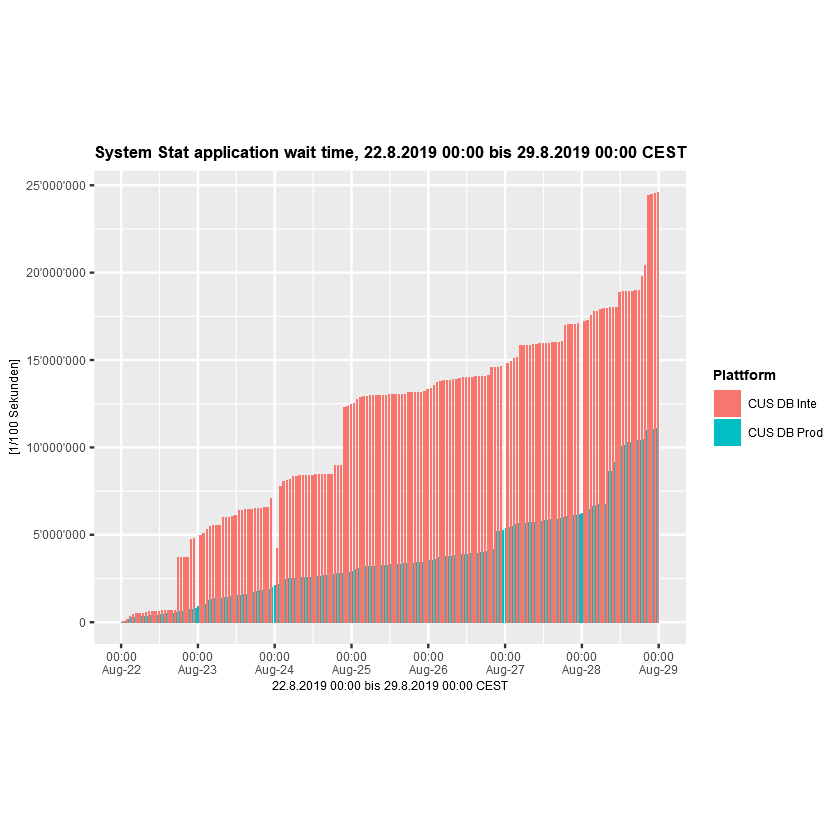

In [19]:
## application wait time
p_awt <- ggplot(data=dtNulled.selectForLoad.melt[ STAT_NAME == "application wait time", ])
p_awt1 <- p_awt + geom_col(aes(x=snapHour, y=value, fill=variable), position="dodge")
p_awt2 <- p_awt1 +
    scale_x_datetime(limits=lims, breaks=tscale, timezone="Europe/Berlin", date_labels="%H:%M\n%b-%d") +
    scale_y_continuous(limits = c(0,NA), labels = scales::comma_format(big.mark="'"))
p_awt3 <- p_awt2 +
    labs(title="System Stat application wait time, 22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    xlab("22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    ylab("[1/100 Sekunden]")
p_awt4 <- p_awt3 + scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod"))
## p_awt5 <- p_awt4 +
##    geom_text(aes(x = tstart + 3600, y=1e7, vjust="inward", hjust="inward",
##    label="application wait time: The total wait time (in centiseconds) \nfor waits that belong to the Application wait class"),
##    size=3.5)
plot(p_awt4 + myTheme)

#### Cluster Waitclass

Warning message:
"Removed 6 rows containing missing values (geom_col)."

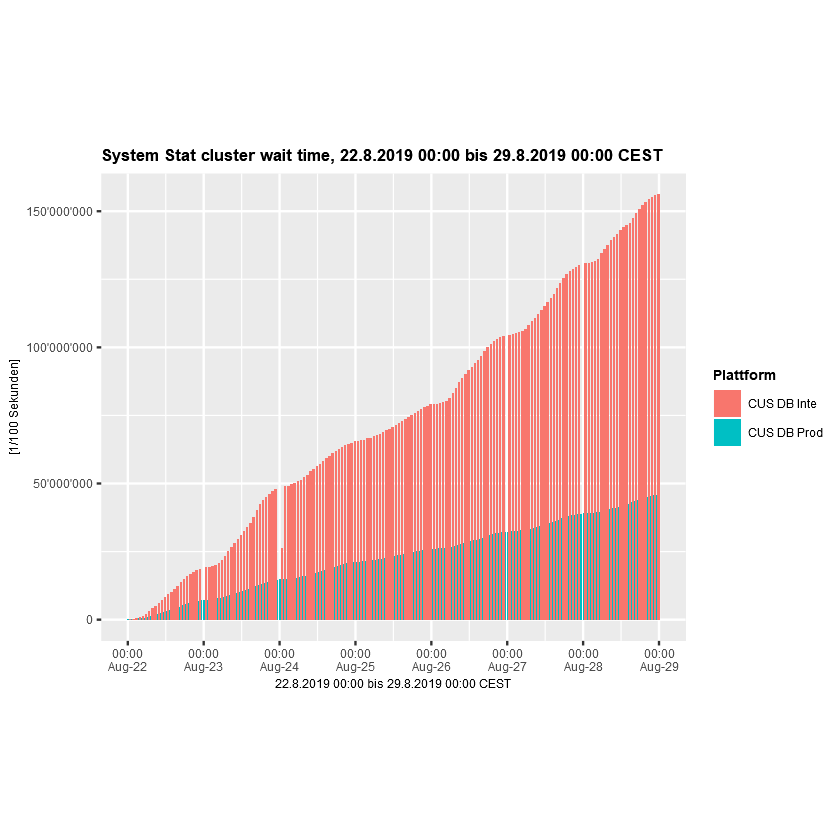

In [15]:
## cluster wait time
p_clwt <- ggplot(data=dtNulled.selectForLoad.melt[ STAT_NAME == "cluster wait time", ])
p_clwt1 <- p_clwt + geom_col(aes(x=snapHour, y=value, fill=variable),  position="dodge")
p_clwt2 <- p_clwt1 +
    scale_x_datetime(limits=lims, breaks=tscale, timezone="Europe/Berlin", date_labels="%H:%M\n%b-%d") +
    scale_y_continuous(limits = c(0,NA), labels = scales::comma_format(big.mark="'"))
p_clwt3 <- p_clwt2 +
    labs(title="System Stat cluster wait time, 22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    xlab("22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    ylab("[1/100 Sekunden]")
p_clwt4 <- p_clwt3 + scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod"))
## p_clwt5 <- p_clwt4 +
##    geom_text(aes(x = tstart + 3600, y=5e7, vjust="inward", hjust="inward",
##    label="cluster wait time: The total wait time (in centiseconds) \nfor waits that belong to the Cluster wait class"),
##    size=5)
plot(p_clwt4 + myTheme)

#### Concurrency Waitclass

Warning message:
"Removed 6 rows containing missing values (geom_col)."

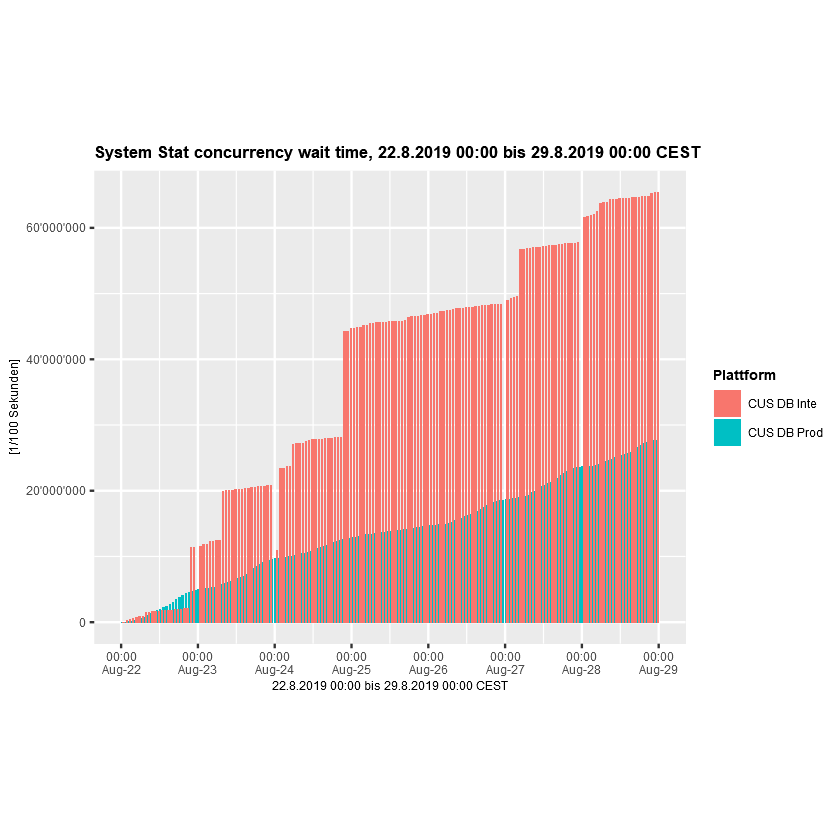

In [20]:
p_ccwt <- ggplot(data=dtNulled.selectForLoad.melt[ STAT_NAME == "concurrency wait time", ])
p_ccwt1 <- p_ccwt + geom_col(aes(x=snapHour, y=value, fill=variable),  position="dodge")
p_ccwt2 <- p_ccwt1 +
    scale_x_datetime(limits=lims, breaks=tscale, timezone="Europe/Berlin", date_labels="%H:%M\n%b-%d") +
    scale_y_continuous(limits = c(0,NA), labels = scales::comma_format(big.mark="'"))
p_ccwt3 <- p_ccwt2 +
    labs(title="System Stat concurrency wait time, 22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    xlab("22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    ylab("[1/100 Sekunden]")
p_ccwt4 <- p_ccwt3 + scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod"))
## p_ccwt5 <- p_ccwt4 +
##    geom_text(aes(x = tstart + 3600, y=2.6e7, vjust="inward", hjust="inward",
##    label="concurrency wait time: The total wait time (in centiseconds) \nfor waits that belong to the Concurrency wait class"),
##    size=5)
plot(p_ccwt4 + myTheme)

#### User I/O Waitclass

Warning message:
"Removed 6 rows containing missing values (geom_col)."

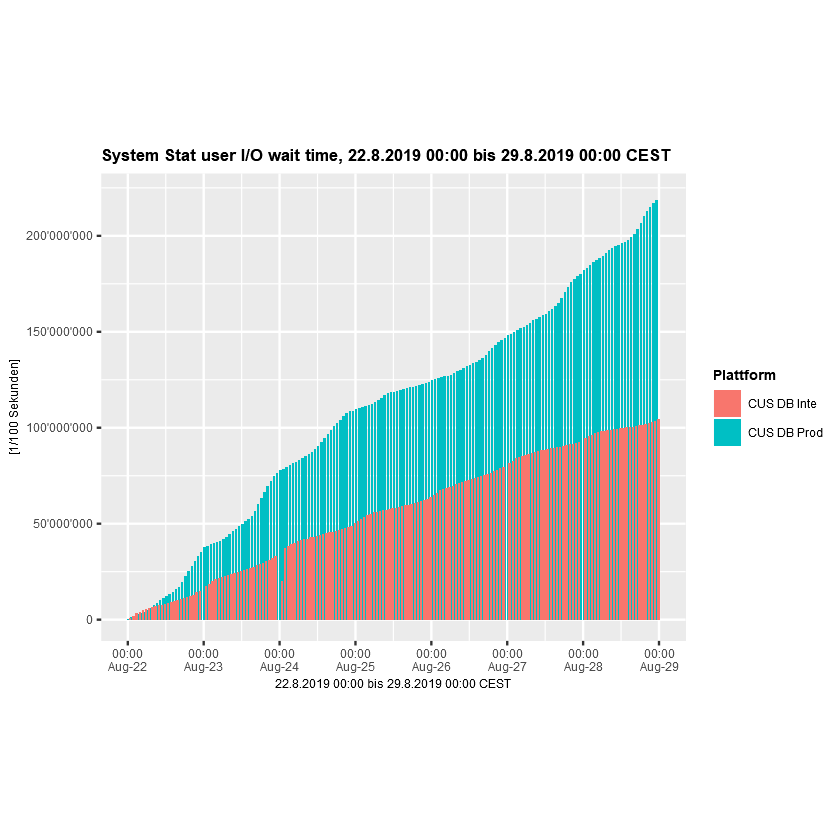

In [24]:
p_uiowt <- ggplot(data=dtNulled.selectForLoad.melt[ STAT_NAME == "user I/O wait time", ])
p_uiowt1 <- p_uiowt + geom_col(aes(x=snapHour, y=value, fill=variable),  position="dodge")
p_uiowt2 <- p_uiowt1 +
    scale_x_datetime(limits=lims, breaks=tscale, timezone="Europe/Berlin", date_labels="%H:%M\n%b-%d") +
    scale_y_continuous(limits = c(0,NA), labels = scales::comma_format(big.mark="'"))
p_uiowt3 <- p_uiowt2 +
    labs(title="System Stat user I/O wait time, 22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    xlab("22.8.2019 00:00 bis 29.8.2019 00:00 CEST") +
    ylab("[1/100 Sekunden]")
p_uiowt4 <- p_uiowt3 + scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod"))
## p_uiowt5 <- p_uiowt4 +
##    geom_text(aes(x = tstart + 3600, y=8.5e7, vjust="inward", hjust="inward",
##    label="user I/O wait time: The total wait time (in centiseconds) for waits that belong to the User I/O wait class"),
##    size=5)
plot(p_uiowt4 + myTheme)